In [3]:
import pandas as pd
import numpy as np
import math
import os
import sys
from pathlib import Path
from IPython.display import display
from enum import Enum
import requests, json
from pprint import pprint
pd.set_option('display.max_columns', None)
import glob
import re
import requests
from tabulate import tabulate
from understatapi.endpoints import MatchEndpoint
from itertools import permutations
import matplotlib.pyplot as plt

In [4]:
%pip install pulp
import pulp
%pip install understatapi
from understatapi import UnderstatClient

Note: you may need to restart the kernel to use updated packages.



In [99]:
# global parameters
num_teams = 20 # number of teams
xG_avg = 1.45 # average number of goals per game for an average team
home_correction = 1.13 # correction applied to home team scoring more than avg and away team less
away_correction = 1.10
inflate_draw = 1.03
avgOPR = 2.19
avgDPR = 0.99
pd.options.display.float_format = "{:,.2f}".format

In [148]:
# import python modules
%run Team

In [117]:
# for now, manually add the teams and power rankings
# the power rankings below are what each team finished on at the end of the 22/23 season
# for the promoted teams, the power rankings are from where they ended up halfway through 23/24 season
teams = []
teams.append(Team("ARS",  0, '#EF0107', 2.74, 0.20))
teams.append(Team("AVL",  1, '#95bfe5', 2.22, 1.12))
teams.append(Team("BOU",  2, '#DA291C', 2.04, 1.00))
teams.append(Team("BRE",  3, '#D20000', 2.09, 0.98))
teams.append(Team("BRI",  4, '#0057B8', 1.86, 0.87))
teams.append(Team("CHE",  6, '#034694', 2.69, 0.96))
teams.append(Team("CRY",  7, '#1B458F', 2.22, 0.66))
teams.append(Team("EVE",  8, '#003399', 1.78, 0.74))
teams.append(Team("FLH",  9, '#000000', 2.01, 0.95))
teams.append(Team("IPS",  5, '#3a64a3', 1.70, 1.30))
teams.append(Team("LEI", 11, '#003090', 1.91, 1.63))
teams.append(Team("LIV", 10, '#c8102E', 2.79, 0.68))
teams.append(Team("MCI", 12, '#6CABDD', 3.00, 0.29))
teams.append(Team("MUN", 13, '#DA291C', 2.21, 1.15))
teams.append(Team("NEW", 14, '#241F20', 2.80, 1.00))
teams.append(Team("NOT", 15, '#DD0000', 1.99, 0.92))
teams.append(Team("SOU", 16, '#d71920', 1.60, 1.66))
teams.append(Team("TOT", 17, '#132257', 2.38, 1.00))
teams.append(Team("WHU", 18, '#7A263A', 2.00, 1.35))
teams.append(Team("WOL", 19, '#FDB913', 1.73, 1.28))

## Team Power Ratings
- Create predicted goal distributions for each match based on the teams' offensive and defensive power rankings
- Compare the predictions with the actual results
- Update teams' power rankings up or down based on over- or underperformance, respectively

In [131]:
# create understat api client
understat = UnderstatClient()

# Specify the league code for the English Premier League (EPL)
league_code = "EPL"

# Specify the season year for the 2024/25 season
season_year = "2024"

# Get match data for the specified league and season
league_data = understat.league(league_code)
matches = league_data.get_match_data(season_year)

In [132]:
update_completed_matches(matches, teams, understat, reset_matchlog=1)

Match # 0
Match # 20
Match # 40
Match # 60
Match # 80
Match # 100
Match # 120
Match # 140
Match # 160
Match # 180
Match # 200
Match # 220
Match # 240
Match # 260
Match # 280
Match # 300


In [133]:
reset_league_PR(teams)
set_leage_alpha(teams, 0.15)
run_season_PR(teams)

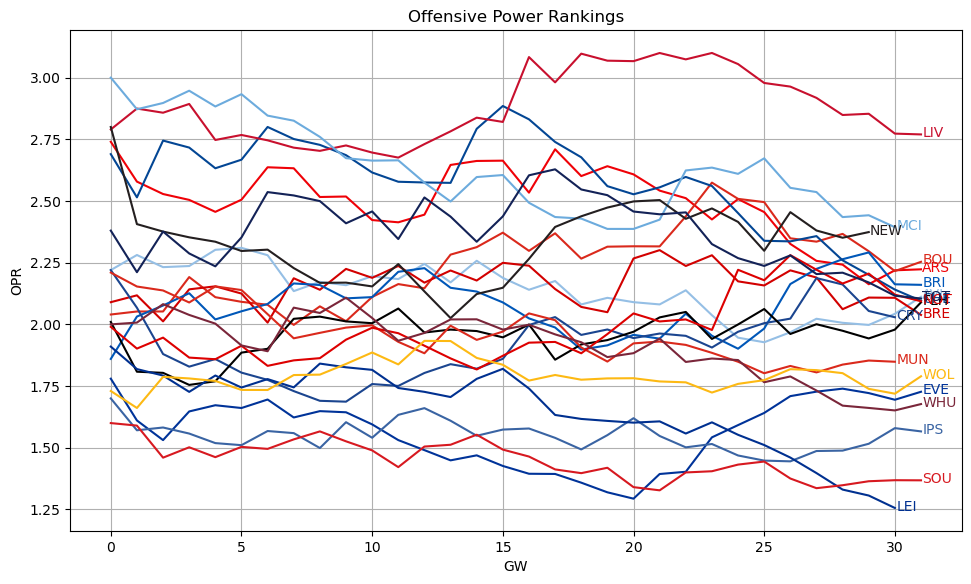

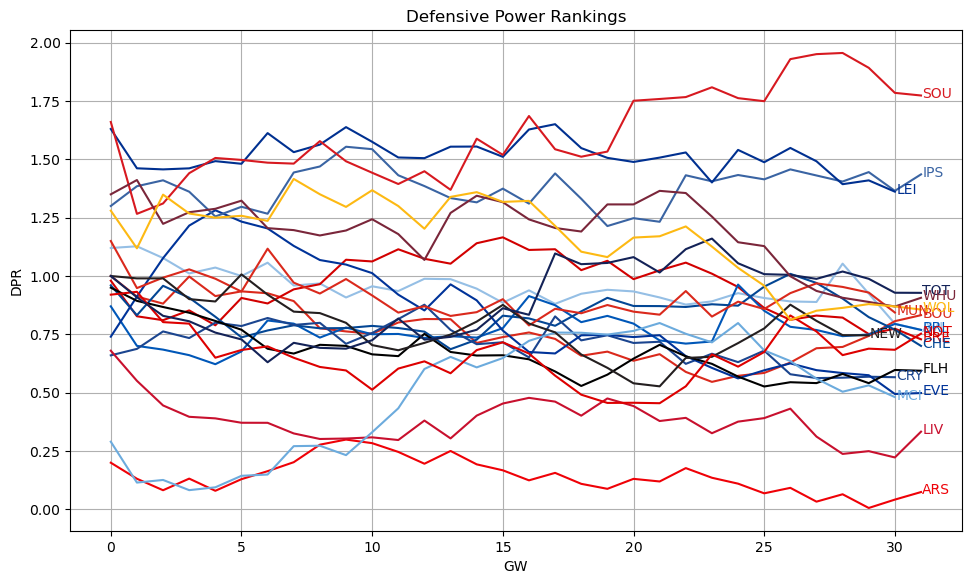

In [149]:
plot_season_PR_all(teams)

C:\Users\Drew\AppData\Local\Temp\ipykernel_9572\3808584038.py:133: RuntimeWarning: invalid value encountered in divide
  plt.plot(CS_cutoffs, np.divide(actCS_bucket, predCS_bucket)*100, linestyle='-', marker='.',color='k')
C:\Users\Drew\AppData\Local\Temp\ipykernel_9572\3808584038.py:143: RuntimeWarning: invalid value encountered in scalar divide
  plt.annotate(str(round(Z))+'/'+str(round(Y)), xy=(X,Z/Y*100), xytext=(-5, 5), ha='right',


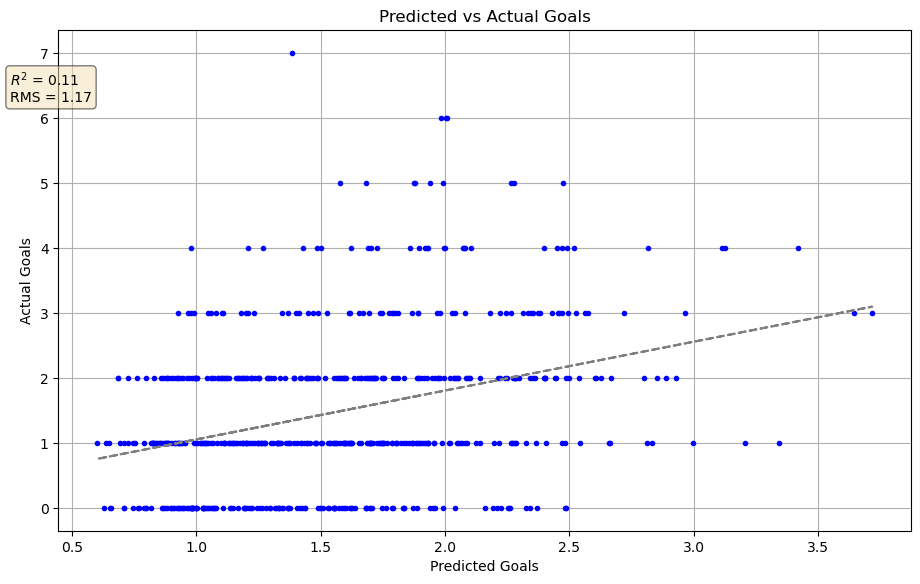

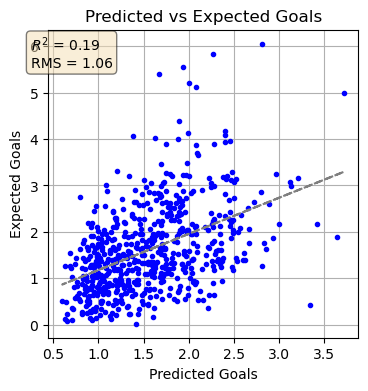

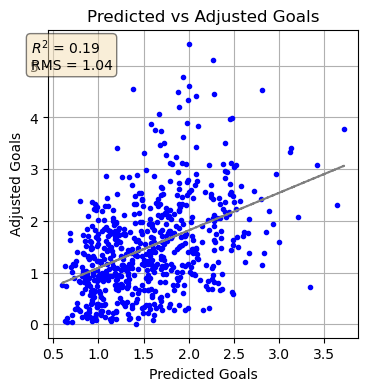

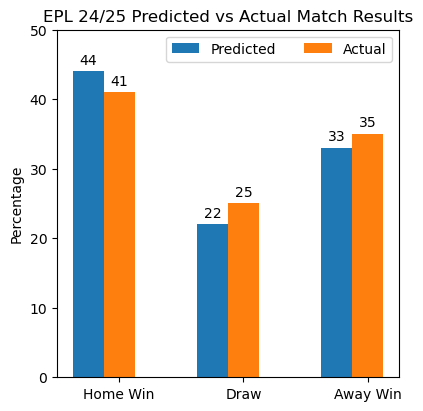

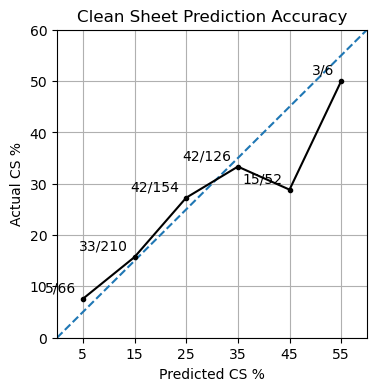

In [150]:
def prediction_accuracy(teams):
    # prints out summary metrics for how well the predictions are doing
    
    matchlog = pd.read_csv(r"data/matchlog24.csv")
    
    # concatenate home and away data
    G = matchlog[['home_G', 'away_G']].to_numpy().flatten()
    predG = matchlog[['home_predG', 'away_predG']].to_numpy().flatten()
    xG = matchlog[['home_xG', 'away_xG']].to_numpy().flatten()
    adjG = matchlog[['home_adjG', 'away_adjG']].to_numpy().flatten()
    errG = matchlog[['home_errG', 'away_errG']].to_numpy().flatten()
    errxG = matchlog[['home_errxG', 'away_errxG']].to_numpy().flatten()
    erradjG = matchlog[['home_erradjG', 'away_erradjG']].to_numpy().flatten()
    
    # get the RMS of the errors
    errG_RMS = ((errG) ** 2).mean() ** .5
    errxG_RMS = ((errxG) ** 2).mean() ** .5
    erradjG_RMS = ((erradjG) ** 2).mean() ** .5
    
    # Linear regression models
    modelG = LinearRegression()
    XG, yG = predG.reshape(-1, 1), G
    #fit regression model
    modelG.fit(XG, yG)
    #calculate R-squared of regression model
    r_squared_G = modelG.score(XG, yG)
    
    modelxG = LinearRegression()
    XxG, yxG = predG.reshape(-1, 1), xG
    #fit regression model
    modelxG.fit(XxG, yxG)
    #calculate R-squared of regression model
    r_squared_xG = modelG.score(XxG, yxG)
    
    modeladjG = LinearRegression()
    XadjG, yadjG = predG.reshape(-1, 1), adjG
    #fit regression model
    modeladjG.fit(XadjG, yadjG)
    #calculate R-squared of regression model
    r_squared_adjG = modeladjG.score(XadjG, yadjG)
    
    # scatter plots
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    plt.figure(1)
    plt.plot(matchlog.home_predG, matchlog.home_G, linestyle='none', marker='.', color='b')
    plt.plot(matchlog.away_predG, matchlog.away_G, linestyle='none', marker='.', color='b')
    plt.plot(XG, modelG.predict(XG), linestyle='--', color='tab:gray')
    plt.text(0.25, max(G)-0.75, '$R^2$ = '+dec2(r_squared_G)+'\nRMS = '+dec2(errG_RMS), bbox=props)
    plt.xlabel('Predicted Goals')
    plt.ylabel('Actual Goals')
    plt.title('Predicted vs Actual Goals')
    plt.grid(True)
    plt.rcParams["figure.figsize"] = (4,4)
    
    plt.figure(2)
    plt.plot(matchlog.home_predG, matchlog.home_xG, linestyle='none', marker='.', color='b')
    plt.plot(matchlog.away_predG, matchlog.away_xG, linestyle='none', marker='.', color='b')
    plt.plot(XxG, modelxG.predict(XxG), linestyle='--', color='tab:gray')
    plt.text(0.25, max(xG)-0.5, '$R^2$ = '+dec2(r_squared_xG)+'\nRMS = '+dec2(errxG_RMS), bbox=props)
    plt.xlabel('Predicted Goals')
    plt.ylabel('Expected Goals')
    plt.title('Predicted vs Expected Goals')
    plt.grid(True)
    plt.rcParams["figure.figsize"] = (4,4)
    
    plt.figure(3)
    plt.plot(matchlog.home_predG, matchlog.home_adjG, linestyle='none', marker='.', color='b')
    plt.plot(matchlog.away_predG, matchlog.away_adjG, linestyle='none', marker='.', color='b')
    plt.plot(XadjG, modeladjG.predict(XadjG), linestyle='--', color='tab:gray')
    plt.text(0.25, max(adjG)-0.5, '$R^2$ = '+dec2(r_squared_adjG)+'\nRMS = '+dec2(erradjG_RMS), bbox=props)
    plt.xlabel('Predicted Goals')
    plt.ylabel('Adjusted Goals')
    plt.title('Predicted vs Adjusted Goals')
    plt.grid(True)
    plt.rcParams["figure.figsize"] = (4,4)
    
    # Result predictions
    sum_p_win = matchlog['p_win'].sum()
    sum_p_draw = matchlog['p_draw'].sum()
    sum_p_loss = matchlog['p_loss'].sum()
    sum_p_tot = sum_p_win + sum_p_draw + sum_p_loss
    sum_p_win = sum_p_win/sum_p_tot
    sum_p_draw = sum_p_draw/sum_p_tot
    sum_p_loss = sum_p_loss/sum_p_tot
    
    result_count = matchlog['actResult'].value_counts(dropna=False)
    result_p_win = result_count.w/(result_count.w + result_count.d + result_count.l)
    result_p_draw = result_count.d/(result_count.w + result_count.d + result_count.l)
    result_p_loss = result_count.l/(result_count.w + result_count.d + result_count.l)
    
    # bar chart with results
    results = ('Home Win','Draw','Away Win')
    result_p = {
        'Predicted': (round(sum_p_win*100), round(sum_p_draw*100), round(sum_p_loss*100)),
        'Actual': (round(result_p_win*100), round(result_p_draw*100), round(result_p_loss*100))
    }
    
    x = np.arange(len(results))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in result_p.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    ax.set_title('EPL 24/25 Predicted vs Actual Match Results')
    ax.set_xticks(x + width, results)
    ax.legend(loc='upper right', ncols=3)
    ax.set_ylim(0, 50)
    
    # Clean sheet accuracy
    predCS = matchlog[['home_predCS', 'away_predCS']].to_numpy().flatten()
    CS = matchlog[['home_CS', 'away_CS']].to_numpy().flatten()
    CS_cutoffs = range(5, 100, 10)
    predCS_bucket = np.zeros(10)
    actCS_bucket = np.zeros(10)
    
    for i in range(0, len(predCS)):
        i_predCS = np.floor(predCS[i]*10)*10
        i_bucket = int(i_predCS/10) # which bucket this one goes in
        predCS_bucket[i_bucket] += 1
        actCS_bucket[i_bucket] += CS[i]
    
    plt.figure(5)
    plt.plot([0, 100], [0, 100], linestyle='--')
    plt.plot(CS_cutoffs, np.divide(actCS_bucket, predCS_bucket)*100, linestyle='-', marker='.',color='k')
    plt.xticks(CS_cutoffs)
    plt.xlabel('Predicted CS %')
    plt.ylabel('Actual CS %')
    plt.title('Clean Sheet Prediction Accuracy')
    plt.grid(True)
    plt.ylim([0, 60])
    plt.xlim([0, 60])
    for X, Y, Z in zip(CS_cutoffs, predCS_bucket, actCS_bucket):
        # Annotate the points 5 _points_ above and to the left of the vertex
        plt.annotate(str(round(Z))+'/'+str(round(Y)), xy=(X,Z/Y*100), xytext=(-5, 5), ha='right',
                    textcoords='offset points')

prediction_accuracy(teams)

In [124]:
GW_summary(matches, teams, 10)

===========Match Summary===========
---------------  ------  ----------
                 EVE     ARS
                 home    away
OPR              1.70    2.22
DPR              0.48    0.04
Predicted Goals  0.69    1.14
Clean Sheet %    31.83   49.45
Home Win %       Draw %  Away Win %
22.06            32.29   45.65
---------------  ------  ----------
===========Match Summary===========
---------------  ------  ----------
                 CRY     BRI
                 home    away
OPR              2.06    2.16
DPR              0.57    0.80
Predicted Goals  1.57    1.16
Clean Sheet %    31.00   20.66
Home Win %       Draw %  Away Win %
46.16            26.05   27.79
---------------  ------  ----------
===========Match Summary===========
---------------  ------  ----------
                 IPS     WOL
                 home    away
OPR              1.58    1.72
DPR              1.36    0.87
Predicted Goals  1.11    1.48
Clean Sheet %    22.49   32.46
Home Win %       Draw %  Away Win %
28

## Fixture Difficulty Rankings
- Looking forward over the selected gameweek period, rank the teams based on how "easy" their fixtures are
- Predicts total goals scored, goals conceded, and number of clean sheets over that time period

In [125]:
matches_FDR = pd.read_csv(r"data/epl-2024-GMTStandardTime.csv")

In [126]:
sched = build_schedule(matches_FDR, teams)

In [127]:
ODR_df, DDR_df = fixture_difficulty_rank(sched, teams, num_rounds=5, start_round=31)

GW Range: 31-35


Team  predG  ODR
0   LIV  11.01 1.63
1   NEW   9.74 1.76
2   MCI   8.53 1.50
3   BRI   8.16 1.67
4   ARS   8.03 1.57
5   TOT   7.93 1.64
6   AVL   7.38 1.63
7   CHE   7.10 1.47
8   BRE   6.91 1.43
9   FLH   6.91 1.57
10  BOU   6.86 1.32
11  NOT   6.80 1.43
12  WOL   6.49 1.73
13  CRY   6.40 1.37
14  WHU   6.26 1.73
15  MUN   5.60 1.46
16  EVE   5.29 1.45
17  LEI   4.80 1.68
18  SOU   4.66 1.62
19  IPS   4.38 1.30

Team  predCS  predGC  DDR
0   ARS    2.29    3.87 1.43
1   LIV    2.17    4.17 1.41
2   MCI    1.91    4.76 1.39
3   NEW    1.59    5.88 1.36
4   EVE    1.58    5.82 1.62
5   BRI    1.43    6.50 1.43
6   FLH    1.40    6.56 1.67
7   WOL    1.38    6.75 1.43
8   NOT    1.37    6.51 1.60
9   CHE    1.35    6.81 1.55
10  CRY    1.34    6.64 1.75
11  BOU    1.32    6.75 1.54
12  AVL    1.30    6.95 1.56
13  TOT    1.26    7.43 1.52
14  BRE    1.23    7.07 1.63
15  WHU    1.14    7.93 1.67
16  MUN    1.05    8.05 1.76
17  LEI    0.78    9.80 1.59
18  IPS    0.72   10.03 1.62
19  SOU    0.58   10.97 1.37

## Player Specific Predictions
- Using the team predictions for goals and goals conceded, adjust the predicted points per player for their fixtures
- Use Linear Programming to select the optimal team over a chosen gameweek range

In [42]:
players2425 = pd.read_csv(r"data\players_raw_2324.csv")
#players2425 = pd.read_csv(r"data\players_raw_2425.csv")

In [43]:
# pre-process players
players2425 = players2425[players2425["selected_by_percent"] > 2.0]
#players = players[players["minutes"] > 400]
players2425["points/90"] = players2425["total_points"]/players2425["minutes"]*90
players2425["team"] = players2425["team"] - 1

conditions = [
    (players2425['element_type'] == 1),
    (players2425['element_type'] == 2),
    (players2425['element_type'] == 3),
    (players2425['element_type'] == 4)
]
position_key = ['GK', 'DEF', 'MID', 'FWD']
players2425['position'] = np.select(conditions, position_key)
players2425 = players2425.reset_index(drop=True)

# Some manual corrections
#players.loc[players['web_name'] == "Bradley", "points_per_game"] = \
    #players.loc[players['web_name'] == "Bradley", "points_per_game"]*0.5
#players.loc[players['web_name'] == "Zinchenko", "points_per_game"] = \
    #players.loc[players['web_name'] == "Zinchenko", "points_per_game"]*0.5
#players.loc[players['web_name'] == "Rodrigo", "points_per_game"] = \
    #players.loc[players['web_name'] == "Rodrigo", "points_per_game"]*0.8
#players.loc[players['web_name'] == "Palmer", "points_per_game"] = \
    #players.loc[players['web_name'] == "Palmer", "points_per_game"]*0.90
#players.loc[players['web_name'] == "Nkunku", "points_per_game"] = \
    #players.loc[players['web_name'] == "Nkunku", "points/90"]*0.8
#players.loc[players['web_name'] == "João Pedro", "points_per_game"] = \
    #players.loc[players['web_name'] == "João Pedro", "points/90"]*1.1

In [44]:
add_gw_ppoints(players2425, sched, num_gw=12, start_gw = 13, decay_rate=1)

In [45]:
my_team = ["Raya","Pedro Porro","Gvardiol","Saka","Palmer","Diogo J.","Mbeumo","Solanke","Foden"]
sara_team = ["Areola","Dunk","Alexander-Arnold","Gvardiol","Palmer","Garnacho","Solanke","Haaland","Watkins"]
include_picks = []
exclude_picks = ["Rodrigo", "Castagne",'Zinchenko','Walker','Diogo J.','Trippier','Alexander-Arnold']

prob = LP_Optimize_Team(players2425, opt_gw="13-19", budget=825, include_players=include_picks, exclude_players=exclude_picks)

1
488.93
Gabriel:   	34.51 points
Saliba:   	36.46 points
White:   	42.32 points
Watkins:   	44.93 points
M.Salah (C):   	107.30 points
Gvardiol:   	30.62 points
Gordon:   	38.27 points
Isak:   	42.06 points
Pope:   	31.10 points
Pedro Porro:   	33.87 points
Son:   	47.49 points


## Dynamic Programming for Optimal Team Planning
- Use dynamic or approximate dynamic programming to plan out a team over the next N gameweeks

In [20]:
class FPL_Team():
    # FPL team composed of 15 players
    num_GK = 2
    num_DEF = 5
    num_MID = 5
    num_FWD = 3
    
    def __init__(self, GKs, DEFs, MIDs, FWDs, free_transfers):
        self.fpl_team = []
        self.fpl_team.append(GKs)
        self.fpl_team.append(DEFs)
        self.fpl_team.append(MIDs)
        self.fpl_team.append(FWDs)
        self.free_transfers = free_transfers
    ## END __init__()
        
    def transfer(self, players_in, players_out):
        if(len(players_in) != len(players_out)):
            print("Invalid transfer: Players out does not match players in.")
            return -1
            
        if(len(players_in) > self.free_transfers):
            print("Invalid transfer: Not enough free transfers available.")
            return -1
            
        for i in range(0, len(players_in)):
            if(players.loc["id" == players_in[i], "position"] != players.loc["id" == players_out[i], "position"]):
                print("Invalid transfer: Position in does not match position out.")
                return -1
                
        for i in range(0, len(players_in)):
            fpl_team.remove(players_out[i])
                
            match players.loc["id" == players_in[i], "position"]:
                case "GK":
                    fpl_team.insert(num_GK-1, players_in[i])
                case "DEF":
                    fpl_team.insert(num_GK+num_def-1, players_in[i])
                case "MID":
                    fpl_team.insert(num_GK+num_DEF+num_MID-1, players_in[i])
                case "FWD":
                    fpl_team.insert(num_GK+num_DEF+num_MID+num_FWD-1, players_in[i])
        ## END loop through transfers
    ## END transfer()

In [110]:
valid_GK = players.index[players["position"] == "GK"].tolist()
valid_DEF = players.index[players["position"] == "DEF"].tolist()
valid_MID = players.index[players["position"] == "MID"].tolist()
valid_FWD = players.index[players["position"] == "FWD"].tolist()


In [104]:
valid_teams = pd.DataFrame(columns=['gk0','gk1','def0','def1','def2','def3','def4',
                                    'mid0','mid1','mid2','mid3','mid4',
                                    'fwd0','fwd1','fwd2'])

valid_teams.to_csv('data/valid_teams.csv', index=False)

In [126]:
def is_team_valid(team):
    # check if the team is a valid FPL team
    for t in range(0, 20):
        team_check  = sum(team[i] for i in range(0, len(team)) if players["team"][i] == t)
        print(team[i] for i in range(0, len(team)))
        if(team_check > 3):
            return False
    
    cost = sum(players["now_cost"][i] for i in range(0, len(team)))
    #print(cost)
    if(cost > 1000 or cost < 900):
        return False
    
    return True

In [127]:
valid_fpl_teams = []

gk_idx = range(0, len(valid_GK))
def_idx = range(0, len(valid_DEF))
mid_idx = range(0, len(valid_MID))
fwd_idx = range(0, len(valid_FWD))

num_GK = 2
num_DEF = 5
num_MID = 5
num_FWD = 3

for gk0 in gk_idx[:len(gk_idx)-num_GK]:
    print("gk0: " + str(gk0))
    for gk1 in gk_idx[gk0+1:]:
        print("gk1: " + str(gk1))
        for def0 in def_idx[:len(def_idx) - num_DEF]:
            for def1 in def_idx[def0+1:len(def_idx) - (num_DEF - 1)]:
                for def2 in def_idx[def1+1:len(def_idx) - (num_DEF - 2)]:
                    for def3 in def_idx[def2+1:len(def_idx) - (num_DEF - 3)]:
                        for def4 in def_idx[def3+1:len(def_idx) - (num_DEF - 4)]:
                            
                            for mid0 in mid_idx[:len(mid_idx) - num_MID]:
                                for mid1 in mid_idx[mid0+1:len(mid_idx) - (num_MID - 1)]:
                                    for mid2 in mid_idx[mid1+1:len(mid_idx) - (num_MID - 2)]:
                                        for mid3 in mid_idx[mid2+1:len(mid_idx) - (num_MID - 3)]:
                                            for mid4 in mid_idx[mid3+1:len(mid_idx) - (num_MID - 4)]:
                                                
                                                for fwd0 in fwd_idx[:len(fwd_idx) - (num_FWD)]:
                                                    for fwd1 in fwd_idx[fwd0+1:len(fwd_idx) - (num_FWD-1)]:
                                                        for fwd2 in fwd_idx[fwd1+1:len(fwd_idx) - (num_FWD-2)]:
                                                            
                                                            candidate_team = [valid_GK[gk0],valid_GK[gk1],
                                                                             valid_DEF[def0],valid_DEF[def1],valid_DEF[def2],valid_DEF[def3],valid_DEF[def4],
                                                                             valid_MID[mid0],valid_MID[mid1],valid_MID[mid2],valid_MID[mid3],valid_MID[mid4],
                                                                             valid_FWD[fwd0],valid_FWD[fwd1],valid_FWD[fwd2]]
                                                            
                                                            valid = is_team_valid(candidate_team)
                                                            if(valid):
                                                                valid_teams = pd.read_csv(r"data/valid_teams.csv")
                                                                valid_teams.loc[len(valid_teams.index)] = candidate_team
                                                                display(valid_teams)
                                                                valid_teams.to_csv('data/valid_teams.csv', index=False)
                                                                



gk0: 0
gk1: 1
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_tea

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<locals>.<genexpr> at 0x0000023B4E47C660>
<generator object is_team_valid.<local

KeyboardInterrupt: 

In [114]:
valid_teams

Empty DataFrame
Columns: [gk0, gk1, def0, def1, def2, def3, def4, mid0, mid1, mid2, mid3, mid4, fwd0, fwd1, fwd2]
Index: []